Logistic Regression Model Trained Successfully!


/tmp/ipython-input-3156397972.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg36.index, y=avg36.values, palette="Blues_d")


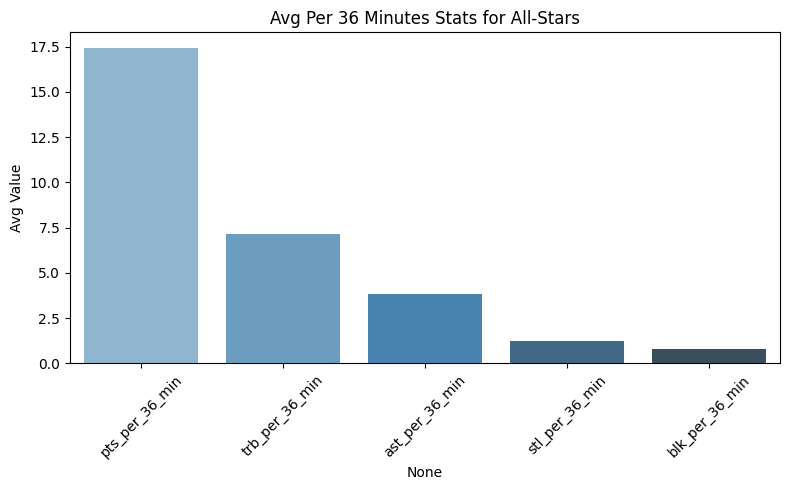

/tmp/ipython-input-3156397972.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg100.index, y=avg100.values, palette="Greens_d")


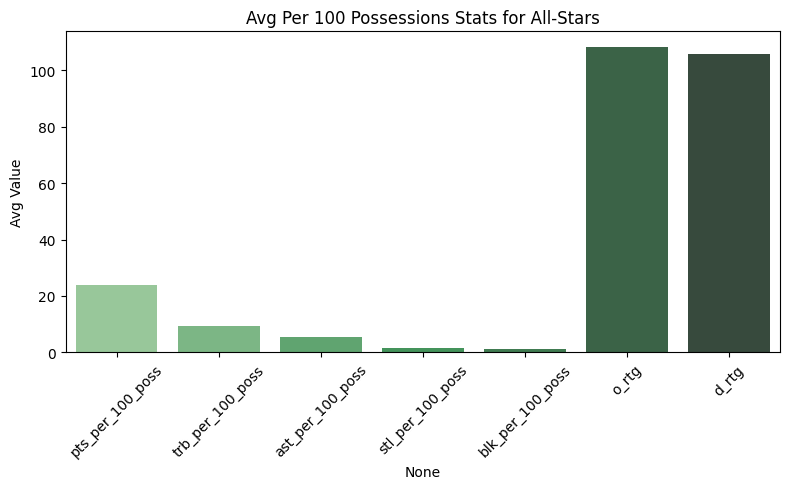

/tmp/ipython-input-3156397972.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avgShoot.index, y=avgShoot.values, palette="Reds_d")


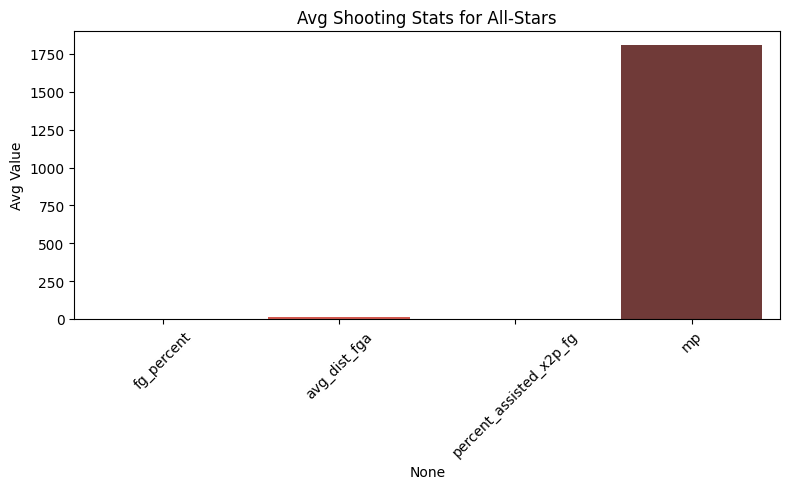

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore

#  data links
url_36 = "https://raw.githubusercontent.com/noelb67750/NBA_DATASET/refs/heads/main/NBA%20Stats/Per%2036%20Minutes.csv"
url_allstar = "https://raw.githubusercontent.com/noelb67750/NBA_DATASET/refs/heads/main/NBA%20Stats/All-Star%20Selections.csv"
url_100 = "https://raw.githubusercontent.com/noelb67750/NBA_DATASET/refs/heads/main/NBA%20Stats/Per%20100%20Poss.csv"
url_shoot = "https://raw.githubusercontent.com/noelb67750/NBA_DATASET/refs/heads/main/NBA%20Stats/Player%20Shooting.csv"

# making dataframes
df36    = pd.read_csv(url_36)
dfAll   = pd.read_csv(url_allstar)
df100   = pd.read_csv(url_100)
dfShoot = pd.read_csv(url_shoot)

allstar_names = dfAll['player'].unique()

# making defenitions
cand_36    = ['pts_per_36_min', 'trb_per_36_min', 'ast_per_36_min', 'stl_per_36_min', 'blk_per_36_min']
cand_100   = ['pts_per_100_poss', 'trb_per_100_poss', 'ast_per_100_poss', 'stl_per_100_poss', 'blk_per_100_poss', 'o_rtg','d_rtg']
cand_shoot = ['fg_percent', 'x3p_percent', 'ft_percent', 'avg_dist_fga', 'percent_assisted_x2p_fg', 'mp']

# filtering and creating new df copy
all36    = df36[df36['player'].isin(allstar_names)].copy()
all100   = df100[df100['player'].isin(allstar_names)].copy()
allShoot = dfShoot[dfShoot['player'].isin(allstar_names)].copy()

# for each loop to ensure columns exist
cols36 = [c for c in cand_36 if c in df36.columns]
cols100 = [c for c in cand_100 if c in df100.columns]
colsShooting = [c for c in cand_shoot if c in dfShoot.columns]

# finding mean
avg36 = all36[cols36].mean()
avg100 = all100[cols100].mean()
avgShoot = allShoot[colsShooting].mean()

# Merge the (df36) and (df100) datasets on the 'player' column.
df_full_merged = pd.merge(df36, df100, on='player', how='inner', suffixes=('_x', '_y'))

# initialize the binary target variable (1=All-Star, 0=Not).
df_full_merged['is_allstar'] = df_full_merged['player'].apply(
    lambda x: 1 if x in allstar_names else 0
)

# FEATURE list for ML model (includes volumn 'mp_x' as the Minutes Played column).
feature_cols = cols36 + cols100 + ['mp_x']

#initializ the Feature Matrix (X) and fill NaNs with 0.
X = df_full_merged[feature_cols].fillna(0)

#the Target Variable (y).
y = df_full_merged['is_allstar']

# Split the data into training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the Logistic Regression model.
# hyperparameter to internally to find best weights
#and good for smaller datasets and binary classifications
allstar_model = LogisticRegression(solver='liblinear', random_state=42)
allstar_model.fit(X_train, y_train)

print("Logistic Regression Model Trained Successfully!")

# Prediction Function also (Probability Percentage)
def predict_allstar_probability(player_name, model, df_full, features):
    player_data = df_full[df_full['player'].str.contains(player_name, case=False, na=False)]

    if player_data.empty:
        return f"Error: Player '{player_name}' not found in the dataset."
#prepares single player data to be input into model for pred
    player_features = player_data[features].iloc[0].values.reshape(1, -1)

    # Predict the probability of being an All-Star (index 1)
    probability = model.predict_proba(player_features)[0][1] * 100

    return f"The model predicts a {probability:.2f}% chance of {player_name} being an All-Star."


def compare_player_to_allstar_average(player_name, df_player_full, df_allstar_stats, features):
    """
    Calculates the Z-Score (likelihood) for a player against the average All-Star
    and graphs the results for simple visual comparison.
    """

    #Data Retrieval and Val
    player_row = df_player_full[df_player_full['player'].str.contains(player_name, case=False, na=False)]

    if player_row.empty:
        print(f"\nError: Player '{player_name}' not found for comparison.")
        return

    # Calculate All-Star Statistics (Mean and Standard Deviation)
    allstar_mean = df_allstar_stats[features].mean()
    allstar_std = df_allstar_stats[features].std()

    player_values = player_row[features].iloc[0].fillna(0)

    # calculate Z-Scores: Z = (X - μ) / σ
    z_scores = (player_values - allstar_mean) / allstar_std

    #Likelihood Summary Score (Average Z-Score)
    likelihood_score = z_scores.mean()

    print("\n------------------------------------------------")
    print(f"LIKELIHOOD ANALYSIS FOR: {player_name}")
    print("--------------------------------------------------")
    print(f"Total Likelihood Score (Avg Z-Score): {likelihood_score:.2f}")

    if likelihood_score >= 0.5:
        print("Likelihood: HIGH. The player is, on average, half a standard deviation better than the typical All-Star.")
    elif likelihood_score >= 0:
        print("Likelihood: MODERATE. The player is statistically comparable to the average All-Star.")
    else:
        print("Likelihood: LOW. The player's current performance profile falls below the average All-Star.")

    #Tabular Z-Score Comparison
    #create df and calls visual report card comparing targets play stats to an avr allstar

    comparison_df = pd.DataFrame({
        'Player Value': player_values,
        'All-Star Mean': allstar_mean,
        'Z-Score (St. Devs)': z_scores.round(2)
    })
    print("\nIndividual Per-36 Stat Comparison:")
    print(comparison_df.sort_values(by='Z-Score (St. Devs)', ascending=False))

    # 6. Graphing the Comparison
    plot_data = pd.DataFrame(z_scores.rename('Z-Score')).reset_index()
    plot_data.columns = ['Stat Metric', 'Z-Score']

    # Create a categorical column for coloring
    plot_data['Performance'] = plot_data['Z-Score'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

    # Define the color map dictionary
    color_map = {'Positive': 'g', 'Negative': 'r'}

    plt.figure(figsize=(10, 6))

    sns.barplot(
        x='Stat Metric',
        y='Z-Score',
        hue='Performance',
        data=plot_data,
        palette=color_map,
        dodge=False
    )

    plt.axhline(0, color='blue', linestyle='--', linewidth=2, label='Average All-Star')

    plt.title(f'Comparison: {player_name} Z-Scores vs. Average All-Star (Per 36 Min)')
    plt.ylabel('Z-Score (Standard Deviations from All-Star Mean)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Performance vs All-Star Mean')
    plt.tight_layout()
    plt.show()


# 36 min stats
plt.figure(figsize=(8,5))
sns.barplot(x=avg36.index, y=avg36.values, palette="Blues_d")
plt.title("Avg Per 36 Minutes Stats for All-Stars")
plt.ylabel("Avg Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 100 pos
plt.figure(figsize=(8,5))
sns.barplot(x=avg100.index, y=avg100.values, palette="Greens_d")
plt.title("Avg Per 100 Possessions Stats for All-Stars")
plt.ylabel("Avg Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# shooying stats
plt.figure(figsize=(8,5))
sns.barplot(x=avgShoot.index, y=avgShoot.values, palette="Reds_d")
plt.title("Avg Shooting Stats for All-Stars")
plt.ylabel("Avg Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ask the user for the player's name
player_name_input = input("Enter the name of the player you want to check (e.g., Stephen Curry): ")

# Run the Logistic Regression model
prediction_result = predict_allstar_probability(
    player_name_input,
    allstar_model,
    df_full_merged,
    feature_cols
)

print("\n=== ALL-STAR PREDICTION RESULT ===")
print(prediction_result)

# 2. Run the Z-Score comparison function
compare_player_to_allstar_average(
    player_name_input,
    df_full_merged,
    all36,       # All-Star only data for comparison
    cols36       # Per 36 min feature names
)